Plan 

I Construction de la base de données
1) Récupération des données INSEE via l'API pynsee
2) Autres données : scraping et import de fichiers en local
3) Fusion des bases de données

II Statistiques descriptives


III Modéliation
1) Régression classique 
2) Détection de grandes périodes et points de rupture

# I Construction de la base de données

## 1) Récupération des données INSEE via l'API pynsee

Notre sujet abordant des questions de politiques publiques, il nous était impensable de ne pas commencer à chercher des données sur le site de l'INSEE. Et nous avons en effet trouvé ce que nous cherchions. Restait encore la question de l'import des bases de données. 
Une première option s'offrait à nous, plus simple, mais plus répétitive et moins performante : télécharger les bases de données une par une, puis les uploader sur le github. 
La seconde option est celle que nous avons utilisée : nous avons importé les bases de données via l'API pynsee, ce qui nous permettait de ne pas rencontrer les mêmes difficultés. 

In [ ]:
#Download Pypi package 
#pip install pynsee[full]
#pip install matplotlib
#pip install seaborn
#pip install scipy

import subprocess
import pandas as pd
import re
import numpy as np

modules = ['pynsee[full]', 'matplotlib', 'seaborn', 'scipy']

for modules in modules:
    subprocess.check_call(["python", '-m', 'pip', 'install', modules])

from pynsee.utils.init_conn import init_conn
init_conn(insee_key='GvulBMLLd4u26RRdMPxYlvqjvHYa', insee_secret='MvDm1OBD_s1a4A33InvrYRT_wEga')

from pynsee.macrodata import * 
from pynsee.macrodata.get_series_list import get_series_list
from pynsee.macrodata.get_series import get_series

Nous avons ensuite créé deux fonctions : 
- clean_filename : 
- import_and_save_data : permet d'importer le fichier souhaité (via l'id_bank de l'INSEE) en le renommant (en donnant le nom souhaité)

In [ ]:

def clean_filename(name):
    return re.sub(r'[^a-zA-Z0-9]', '_', str(name))

def import_and_save_data(id_bank, dataframe_name):
    data = get_series(id_bank)
    data_filtered = data.loc[:, ['DATE', 'OBS_VALUE']] #Sélection des variables d'intérêt
    data_filtered['DATE'] = pd.to_datetime(data_filtered['DATE'])

    new_column_name = clean_filename(dataframe_name) 
    data_filtered = data_filtered.rename(columns={'OBS_VALUE': new_column_name}) # Renommer la colonne OBS_VALUE avec le nom du df
    print(data_filtered.head()) #Vérification des données

    csv_filename = f'datas/{clean_filename(dataframe_name)}_filtered.csv'
    data_filtered.to_csv(csv_filename, index=False) #Sauvegarde dans un fichier csv

    return data_filtered

Il ne nous restait donc plus qu'à exécuter le code pour les données que nous souhaitions importer : 

In [ ]:
governement_negotiable_debts = import_and_save_data('001711531', 'negotiable_debts')
data_firms_creation = import_and_save_data('010755537', 'firms_creation')
data_unemployment_rate = import_and_save_data('001515842', 'unemployment_rate')
data_BOP = import_and_save_data('001694057', 'BOP')
data_natality_rate = import_and_save_data('000436392', 'natality_rate')
data_business_insolvencies = import_and_save_data('001656164', 'business_insolvencies')

## 2) Import des autres données : 

   ### 2-1 Taux de change et CAC40

Afin de récupérer le taux de change ainsi que l'indice du CAC 40, il n'était pas possible de recourir à la base de données de l'INSEE. Nous avons cependant trouvé des données en open-data, disponibles à ces adresses : 
- https://www.investing.com/currencies/eur-usd-historical-data pour le taux de change au certain €/$
- https://fr.investing.com/indices/france-40-historical-data pour le CAC 40

Cette méthode présente néanmoins les mêmes désavantages que ceux listés pour la première option de l'import des bases de données de l'INSEE. Nous l'avons donc seulement choisie en raison du nombre limité de bases de données à importer (deux) et d'absence d'autres bases aussi accessibles et complètes.
Il ne suffisait que de retravailler les données afin d'obtenir le format de date souhaité et le format anglo-saxon pour les float (. à la place de ,)

In [ ]:
import pandas as pd
import os

#NOTE : essayer d'upload les fichiers sur GITHUB pour que ce soit plus reproductible

destination_folder = "datas"
files = {
    'C:\\Users\\mathi\\Downloads\\CAC 40 Historical Data (2).csv': 'CAC_40.csv',
    'C:\\Users\\mathi\\Downloads\\EUR_USD Historical Data (3).csv': 'EUR_USD.csv'
}

for file_path, new_name in files.items():
    df = pd.read_csv(file_path, encoding='utf-8')
    df.rename(columns={'Date': 'DATE'}, inplace=True)
    df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y', errors='coerce') #Conversion de la date à un format standard
    df['DATE'] = df['DATE'].dt.strftime('%Y-%m-%d')
    print("date successful")

    if new_name == 'CAC_40.csv':    
        df = df[['DATE', 'Price']]
        df.rename(columns={'Price': 'Valuation'}, inplace=True)
        print(new_name, df.head())
        df['Valuation'] = df['Valuation'].str.replace('.', '').str.replace(',', '.').str.replace('"', '').astype(float)
    
    elif new_name == 'EUR_USD.csv':
        df = df[['DATE', 'Price']]
        df.rename(columns={'Price': 'Exch_rate'}, inplace=True)
        print(new_name, df.head())
        df['Exch_rate'] = df['Exch_rate'].replace({',': '.', '"': ''}, regex=True).astype(float)

    new_path = os.path.join(destination_folder, new_name)
    df.to_csv(new_path, index=False)

Un autre challenge restait celui de la récupération des taux directeurs. En effet, ceux-ci jouent un rôle clé dans l'évolution de la dette en ce qu'ils déterminent les intérêts à payer. Nous avons décidé de les récupérer sur le site de la Banque Centrale Européenne (BCE, ou ECB en anglais). Cette fois-ci avec plusieurs difficultés : 
- les années n'étaient pas présentes sur toutes les lignes et pouvaient fonctionner par "groupe"  
- les dates n'étaient pas au format standard mais avec des abréviations
- les numéros de note pour les notes de bas de page étaient affichés dans la date. Ex : 15 Oct.4

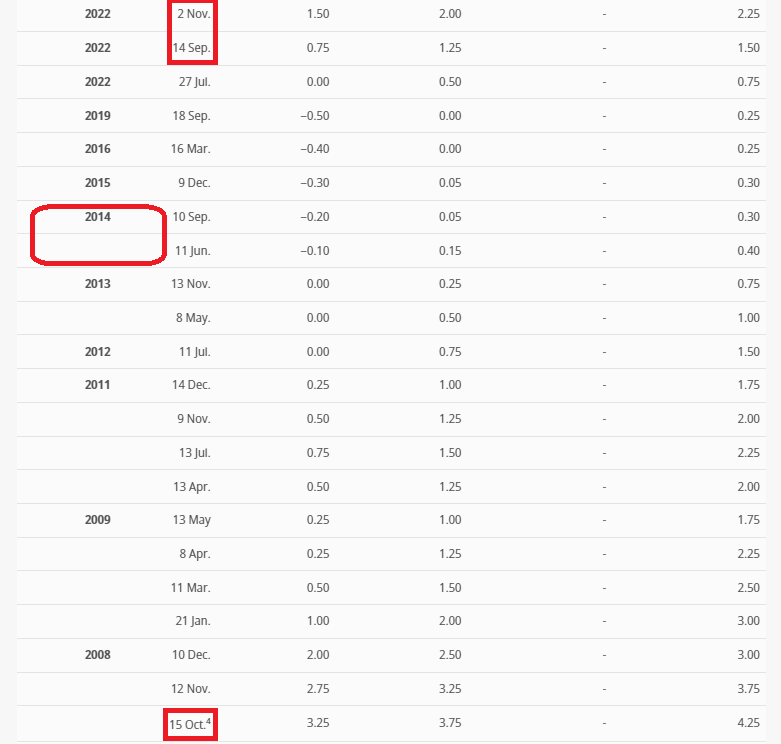

In [1]:
#Installation des modules 


#Import des librairies
# pip install -q lxml
# pip install webdriver-manager

import subprocess
import pandas as pd


modules = ["lxml", "webdriver-manager", "bs4"]
for module in modules:
    subprocess.run(["pip", "install", module])

import bs4
import lxml
import urllib
import re


from urllib import request
from datetime import datetime

url_ecb = "https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html"

request_text = request.urlopen(url_ecb).read()
page = bs4.BeautifulSoup(request_text, "html.parser")

policy_rates_df = page.find('table')
table_body = policy_rates_df.find('tbody')
rows = table_body.find_all('tr')

#Completing the first column with the previous value if there is none

data_temp = []

for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if cols[0] == '':
        cols[0] = previous_value
    previous_value = cols[0]
    data_temp.append(cols)

columns = ['Year', 'Date', 'Deposit facility', 'Fixed rate', 'Minimum bid rate', 'Marginal lending facility']
policy_rates_df = pd.DataFrame(data_temp, columns=columns)
print(policy_rates_df.head())


   Year     Date Deposit facility Fixed rate Minimum bid rate  \
0  2023  20 Sep.             4.00       4.50                -   
1  2023   2 Aug.             3.75       4.25                -   
2  2023  21 Jun.             3.50       4.00                -   
3  2023   10 May             3.25       3.75                -   
4  2023  22 Mar.             3.00       3.50                -   

  Marginal lending facility  
0                      4.75  
1                      4.50  
2                      4.25  
3                      4.00  
4                      3.75  


Une fois le problème des années pas toujours présentes dans la première colonne, il nous a fallu régler les deux problèmes restants (pas de date dans un format standard comme DD/MM/YYYY, mais avec des abréviations).
Nous avons d'abord tenté d'utiliser pd.to_datetime, mais il s'est avéré qu'il n'arrivait pas bien à assimiler le format. Nous avons alors eu l'idée d'utiliser une expression régulière : 
- (\d{1,2}): correspond à 1 ou 2 chiffres (\d) qui représentent le jour du mois 
- \s: un espace ou une tabulation (dans notre cas, l'espace entre le jour et l'abréviation du mois)
- (\w{3}): 3 caractères alphanumériques, représentant les abréviations de tous les mois étaient abrégés avec 3 caractères alphanumériques

Nous avons ensuite utilisé la fonction Map afin de passer des abréviations des mois au format souhaité YYYY-MM-DD

In [2]:
extracted_date = policy_rates_df['Date'].str.extract(r'(\d{1,2})\s(\w{3})')

month_map = {
    'Jan': '-01-', 'Feb': '-02-', 'Mar': '-03-',
    'Apr': '-04-', 'May': '-05-', 'Jun': '-06-',
    'Jul': '-07-', 'Aug': '-08-', 'Sep': '-09-',
    'Oct': '-10-', 'Nov': '-11-', 'Dec': '-12-'
}

# Constructing the date such that format is YYYY-MM-DD
policy_rates_df['Date'] = (
    policy_rates_df['Year'].astype(str) + 
    extracted_date[1].map(month_map) + 
    extracted_date[0].astype(str)
)

policy_rates_df['Date'] = pd.to_datetime(policy_rates_df['Date'], format='%Y-%m-%d', errors='coerce')
print(policy_rates_df.head())

#Making sure that the wished float values are indeed float

field_float = ['Deposit facility', 'Fixed rate', 'Minimum bid rate', 'Marginal lending facility']

for col in field_float:
    policy_rates_df[col] = pd.to_numeric(policy_rates_df[col], errors='coerce')

policy_rates_df[field_float] = policy_rates_df[field_float].astype(float)


policy_rates_df.drop('Year', axis=1, inplace=True) #Dropping the column Year as it is redundant 
print(policy_rates_df.head())  

policy_rates_df.to_csv('datas/' + 'policy_rates.csv', index=False) #saving the file as csv

   Year       Date Deposit facility Fixed rate Minimum bid rate  \
0  2023 2023-09-20             4.00       4.50                -   
1  2023 2023-08-02             3.75       4.25                -   
2  2023 2023-06-21             3.50       4.00                -   
3  2023 2023-05-10             3.25       3.75                -   
4  2023 2023-03-22             3.00       3.50                -   

  Marginal lending facility  
0                      4.75  
1                      4.50  
2                      4.25  
3                      4.00  
4                      3.75  
        Date  Deposit facility  Fixed rate  Minimum bid rate  \
0 2023-09-20              4.00        4.50               NaN   
1 2023-08-02              3.75        4.25               NaN   
2 2023-06-21              3.50        4.00               NaN   
3 2023-05-10              3.25        3.75               NaN   
4 2023-03-22              3.00        3.50               NaN   

   Marginal lending facility  
0

Enfin, étant donné que notre objectif était d'avoir une base de données avec des données mensuelles, il a fallu créer un nouveau dataframe avec des données mensuelles, et remplir les valeurs avec celles les plus proches.

In [4]:
policy_rates_df['Date'] = pd.to_datetime(policy_rates_df['Date'], format='%Y-%m-%d', errors='coerce')
numeric_cols = policy_rates_df.select_dtypes(include='number').columns
policy_rates_df[numeric_cols] = policy_rates_df[numeric_cols].ffill()

#Creation of a new dataframe with monthly data (month starts) 
date_range = pd.date_range(start=min(policy_rates_df['Date']), end=max(policy_rates_df['Date']), freq='MS')
policy_rates_monthly = pd.DataFrame({'Date': date_range})

# Find closest date in the original df and complete the values in the monthly df

for index, row in policy_rates_monthly.iterrows():
    closest_date = policy_rates_df['Date'].iloc[(policy_rates_df['Date'] - row['Date']).abs().argsort()[:1]].values[0]    
    policy_rates = policy_rates_df[policy_rates_df['Date'] == closest_date].drop('Date', axis=1)
    policy_rates_monthly.loc[index, policy_rates.columns] = policy_rates.values[0]

policy_rates_monthly = policy_rates_monthly.rename(columns={'Date': 'DATE'}) 
print(policy_rates_monthly.head())
policy_rates_monthly.to_csv('datas/policy_rates_monthly.csv', index=False)


        DATE  Deposit facility  Fixed rate  Minimum bid rate  \
0 1999-01-01               2.0         3.0              4.25   
1 1999-02-01               2.0         3.0              4.25   
2 1999-03-01               2.0         3.0              4.25   
3 1999-04-01               1.5         2.5              4.25   
4 1999-05-01               1.5         2.5              4.25   

   Marginal lending facility  
0                        4.5  
1                        4.5  
2                        4.5  
3                        3.5  
4                        3.5  
